# Imports

In [2]:
from skimage import filters
from skimage import io, color
import numpy as np
from scipy.ndimage import convolve, maximum_filter
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #avoid annoying imshow deprecated
import math
from typing import Literal
from tqdm import tqdm
import torch
import time
from skimage.segmentation import slic, mark_boundaries

import utils

# Simple data loading / sanity checking

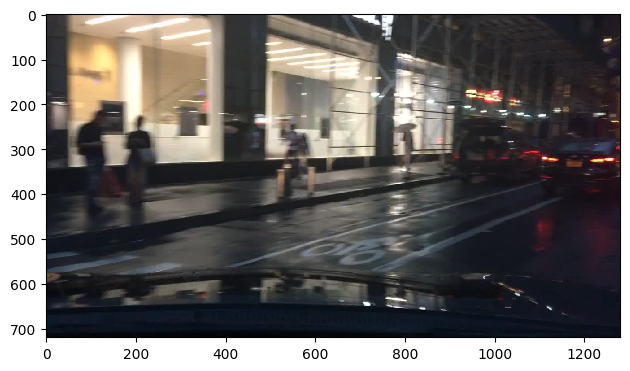

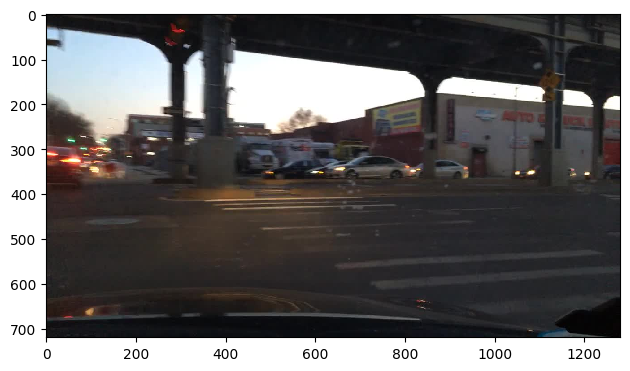

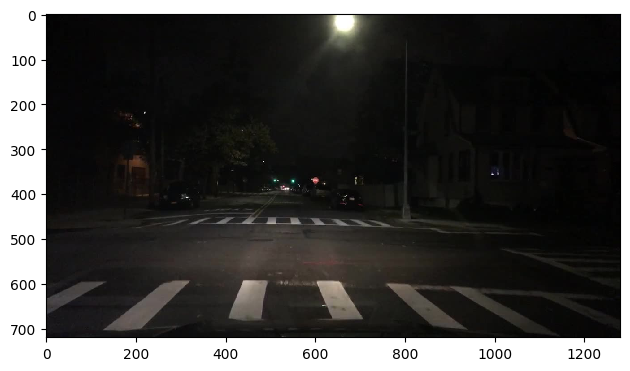

In [3]:
sample_images = utils.get_sample_images()
utils.plot_sample_images(sample_images[:3])

# Mean Shift Clustering

In [4]:
sample_img = sample_images[1]
sample_img.shape #row x col x color

(720, 1280, 3)

In [5]:
sample_img

array([[[32, 32, 32],
        [32, 32, 32],
        [31, 31, 31],
        ...,
        [29, 29, 31],
        [30, 30, 32],
        [31, 31, 33]],

       [[26, 26, 26],
        [26, 26, 26],
        [25, 25, 25],
        ...,
        [29, 29, 31],
        [30, 30, 32],
        [31, 31, 33]],

       [[20, 20, 20],
        [20, 20, 20],
        [19, 19, 19],
        ...,
        [29, 29, 31],
        [30, 30, 32],
        [31, 31, 33]],

       ...,

       [[18, 18, 20],
        [18, 18, 20],
        [20, 20, 22],
        ...,
        [ 8,  6,  7],
        [12, 10, 11],
        [14, 12, 13]],

       [[17, 17, 19],
        [18, 18, 20],
        [19, 19, 21],
        ...,
        [ 9,  7,  8],
        [13, 11, 12],
        [15, 13, 14]],

       [[16, 16, 18],
        [17, 17, 19],
        [19, 19, 21],
        ...,
        [ 9,  7,  8],
        [13, 11, 12],
        [15, 13, 14]]], shape=(720, 1280, 3), dtype=uint8)

# Get X: 
[x,y,r,g,b] for px in img

In [6]:
xs = []
for i in range(len(sample_img)):
    for j in range(len(sample_img[i])):
        xs.append(np.hstack((np.array(i), np.array(j), np.array(sample_img[i,j]))))

xs

[array([ 0,  0, 32, 32, 32]),
 array([ 0,  1, 32, 32, 32]),
 array([ 0,  2, 31, 31, 31]),
 array([ 0,  3, 30, 30, 30]),
 array([ 0,  4, 28, 28, 28]),
 array([ 0,  5, 27, 27, 27]),
 array([ 0,  6, 26, 26, 26]),
 array([ 0,  7, 25, 25, 25]),
 array([ 0,  8, 26, 26, 26]),
 array([ 0,  9, 26, 26, 26]),
 array([ 0, 10, 26, 26, 26]),
 array([ 0, 11, 26, 26, 26]),
 array([ 0, 12, 26, 26, 26]),
 array([ 0, 13, 26, 26, 26]),
 array([ 0, 14, 26, 26, 26]),
 array([ 0, 15, 27, 26, 24]),
 array([ 0, 16, 28, 24, 23]),
 array([ 0, 17, 30, 25, 22]),
 array([ 0, 18, 31, 26, 23]),
 array([ 0, 19, 33, 28, 25]),
 array([ 0, 20, 34, 29, 26]),
 array([ 0, 21, 36, 31, 28]),
 array([ 0, 22, 37, 32, 29]),
 array([ 0, 23, 38, 33, 30]),
 array([ 0, 24, 36, 31, 28]),
 array([ 0, 25, 36, 31, 28]),
 array([ 0, 26, 36, 31, 28]),
 array([ 0, 27, 36, 31, 28]),
 array([ 0, 28, 36, 31, 28]),
 array([ 0, 29, 36, 31, 28]),
 array([ 0, 30, 36, 31, 28]),
 array([ 0, 31, 35, 31, 28]),
 array([ 0, 32, 37, 35, 36]),
 array([ 0

^ slow version \
faster:

In [7]:
h, w, _ = sample_img.shape
xs = np.arange(h)
ys = np.arange(w)
xx, yy = np.meshgrid(xs, ys, indexing='ij')

X = np.column_stack((
    xx.ravel(),
    yy.ravel(),
    sample_img.reshape(-1, 3)
))
X

array([[   0,    0,   32,   32,   32],
       [   0,    1,   32,   32,   32],
       [   0,    2,   31,   31,   31],
       ...,
       [ 719, 1277,    9,    7,    8],
       [ 719, 1278,   13,   11,   12],
       [ 719, 1279,   15,   13,   14]], shape=(921600, 5))

In [8]:
sample_img_downsized = utils.resize_images([sample_img], target_size=(90, 160))[0]

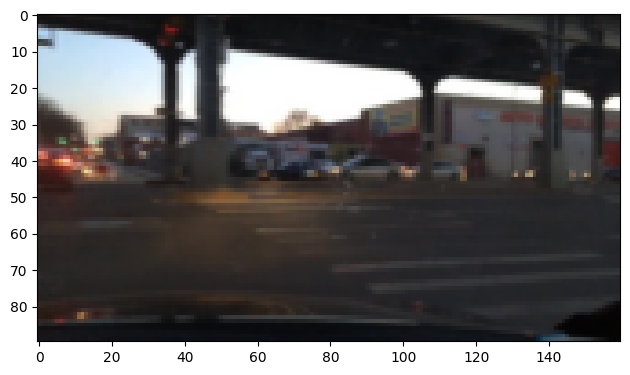

In [9]:
io.imshow(sample_img_downsized)

In [10]:
sample_img_downsized.max()

np.float64(1.0)

In [11]:
sample_img_downsized = (sample_img_downsized * 255).astype(np.uint8)
sample_img_downsized.max()

np.uint8(255)

In [12]:
def _compute_X(img):
    h, w, _ = img.shape
    xs = np.arange(h)
    ys = np.arange(w)
    xx, yy = np.meshgrid(xs, ys, indexing='ij')

    return np.column_stack((
        xx.ravel(),
        yy.ravel(),
        img.reshape(-1, 3)
    ))
    

def mean_shift_unvectorized(
    image: np.ndarray,
    max_iter: int = 20,
    bandwith: int = 5,
    eps: float = 1e-8,
    distance_fn: Literal['L2', 'L1', 'cos'] = 'L2',
    kernel_fn: Literal['gaussian'] = 'gaussian' #can extend
):
    """
    Implementation to segment image with mean shift.

    image: image to cluster
    max_iter: stop once iter==max_iter
    kernel_fn: kernel for use in KDE (only support gaussian for now)
    """
    ROWS, COLS, CHANNELS = image.shape

    assert distance_fn in ['L2', 'L1', 'cos'], 'invalid distance fn'
    assert kernel_fn in ['gaussian'], 'invalid kernel fn'
    assert CHANNELS == 3, 'color channels not equal to 3'

    X = _compute_X(image)
    N = X.shape[0]

    for i in range(max_iter):
        dist = .0

        new_pts = np.zeros_like(X, dtype=float)

        for i in tqdm(range(N)):
            curr_pt = X[i]

            dists = utils.compute_distance(curr_pt, X, distance_fn)
            wts = utils.compute_KDE(dists, bandwith, kernel_fn)

            new_loc = np.sum(X * wts[:,None], axis=0) / (np.sum(wts) + eps)
            new_pts[i] = new_loc

            shift = np.sqrt(np.sum((new_loc - curr_pt)**2))
            if shift > dist: dist = shift

        X = new_pts.copy()

        if dist < .5: break #convergence cond

    colors = X[:, 2:] #rgb
    segmented_img = np.clip(colors,0,255).astype(np.uint8)
    return segmented_img.reshape(ROWS, COLS, 3)

res = mean_shift_unvectorized(sample_img_downsized, max_iter=10)

100%|██████████| 14400/14400 [00:05<00:00, 2845.76it/s]


100%|██████████| 924/924 [00:00<00:00, 26321.94it/s]


Mean shift FPS (on SLIC superpixels):  27.586119807424165


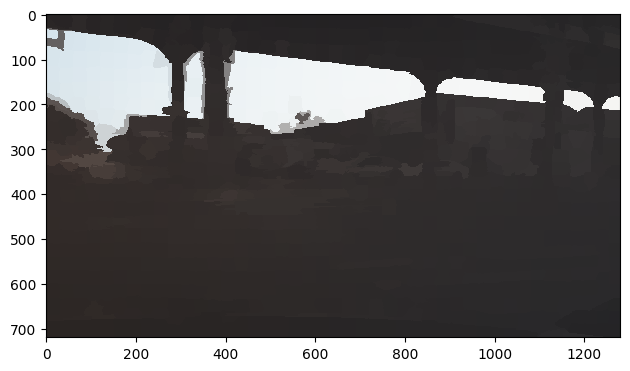

In [13]:
def _compute_X_SLIC(img):
    labels = slic(
        img,
        n_segments=1000,
        compactness=10,
        start_label=0,
        max_num_iter=5
    )

    H, W = labels.shape
    K = labels.max() + 1

    X = np.zeros((K, 5), dtype=float)

    for sp in range(K):
        mask = (labels == sp)
        rows, cols = np.where(mask)

        R = img[:,:,0][mask]
        G = img[:,:,1][mask]
        B = img[:,:,2][mask]

        # Correct normalization
        X[sp, 0] = rows.mean() / H
        X[sp, 1] = cols.mean() / W
        X[sp, 2] = R.mean() / 255.0
        X[sp, 3] = G.mean() / 255.0
        X[sp, 4] = B.mean() / 255.0

    return X, labels

    
def mean_shift_slic(
    image: np.ndarray,
    max_iter: int = 20,
    bandwith: int = 0.3,
    eps: float = 1e-8,
    distance_fn: Literal['L2', 'L1', 'cos'] = 'L2',
    kernel_fn: Literal['gaussian'] = 'gaussian' #can extend
):
    """
    Implementation to segment image with mean shift.

    image: image to cluster
    max_iter: stop once iter==max_iter
    kernel_fn: kernel for use in KDE (only support gaussian for now)
    """
    ROWS, COLS, CHANNELS = image.shape

    assert distance_fn in ['L2', 'L1', 'cos'], 'invalid distance fn'
    assert kernel_fn in ['gaussian'], 'invalid kernel fn'
    assert CHANNELS == 3, 'color channels not equal to 3'

    X, labels = _compute_X_SLIC(image)
    N = X.shape[0]

    time_s = time.time()
    for i in range(max_iter):
        dist = .0

        new_pts = np.zeros_like(X, dtype=float)

        for i in tqdm(range(N)):
            curr_pt = X[i]

            dists = utils.compute_distance(curr_pt, X, distance_fn)
            wts = utils.compute_KDE(dists, bandwith, kernel_fn)

            new_loc = np.sum(X * wts[:,None], axis=0) / (np.sum(wts) + eps)
            new_pts[i] = new_loc

            shift = np.sqrt(np.sum((new_loc - curr_pt)**2))
            if shift > dist: dist = shift

        X = new_pts.copy()

        if dist < .5: break #convergence cond

    print('Mean shift FPS (on SLIC superpixels): ', 1 / (time.time() - time_s))
    R = X[:, 2] * 255.0
    G = X[:, 3] * 255.0
    B = X[:, 4] * 255.0

    rgb_colors = np.stack([R, G, B], axis=1)

    segmented_rgb = np.zeros((ROWS, COLS, 3), dtype=float)

    for sp in range(rgb_colors.shape[0]):
        mask = (labels == sp)
        segmented_rgb[mask] = rgb_colors[sp]

    segmented_rgb = np.clip(segmented_rgb, 0, 255).astype(np.uint8)

    return segmented_rgb

res = mean_shift_slic(sample_img, max_iter=10)
io.imshow(res)

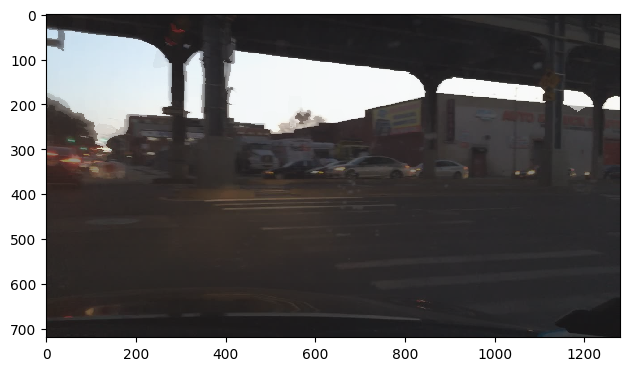

In [14]:
def overlay_segmentation(img, seg, alpha=0.5):
    """
    Blend original image with segmentation result.
    alpha=0 → original, alpha=1 → segmentation.
    """
    img = img.astype(float)
    seg = seg.astype(float)
    blended = (1 - alpha) * img + alpha * seg
    return blended.clip(0, 255).astype(np.uint8)

io.imshow(overlay_segmentation(sample_img, res, alpha=0.6))